<a href="https://colab.research.google.com/github/hillspen/MNIST_Gan/blob/main/Spencer_MNIST_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras Gan Model to Produce Hand-Written Digits


Created by Spencer Hill November 26, 2020. Last updated December 8, 2020.

Sources Referenced:
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/



In [ ]:
#importation of required numpy, keras, and matplotlib functions
import time
import tensorflow as tf
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot as plt

## Model Definitions and Architecture
  - Discriminator model complexity was minimized while still maintaining high accuracy (>98% when independently trained);
  - Generator model accepts latent vector (dimension of 100 is used as is standard pracitce) and creates grayscale 28 X 28 image;
  - Gan combines two models and sets the discriminator (which will be trained separately) to untrainable.

Final gan model accepts latent vector and outputs a value between [0, 1] representing how realistic the discriminator thought the internally created and tested model was

In [ ]:
#code defining the discriminator model. 
def create_discriminator(shape_in = (28, 28, 1)): #input shape will always be (28, 28, 1)
  discriminator = Sequential()
  discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=shape_in))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.4))
  discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.4))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  # compile discriminator
  opt = Adam(lr=0.0002, beta_1=0.5)
  discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return  discriminator

In [ ]:
#defining generator model. Inputs latent_vector and creates (28, 28, 1) output betweeen [0, 1]
def create_generator(latent_dimension, num_parallel_images = 128):
  model = Sequential()
  #define lower-resolution inital size which will be sequentially increased
  initial_dimension = 7 
  #model architecture
  model.add(Dense((initial_dimension ** 2) * num_parallel_images, input_dim=latent_dimension))
  model.add(LeakyReLU(alpha=0.2))
  #creating 3D layer of size (7, 28, 28)
  model.add(Reshape((7, 7, 128)))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  #making the strides a factor of the kernel will reduce checkerboarding
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

  return model

In [ ]:
#gan model accepts latent vector (dimension of 100 is used here) and outputs value between [0, 1]
def create_gan(g_model, d_model): #g_model is generator, d_model is discriminator
	# make weights in the discriminator not trainable
	d_model.trainable = False
	#initialize connected model
	model = Sequential()
	# add generator
	model.add(g_model)
	#add discriminator
	model.add(d_model)
  #adam learning rate of 0.0002 is standard for this problem
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='kl_divergence', optimizer=opt)
	return model

## Helper Functions
Functions to aid in the training and evaluation of the gan model. These include:
  - Loading the MNIST data samples;
  - Generating random real samples from MNIST dataset;
  - Creating latent vectors;
  - Using the previously defined generator model to create fake samples;
  - Plotting grayscale images from 28 X 28 pixel vectors;
  - Summarizing and displaying the gan model performance.


In [ ]:
#import the MNIST dataset, normalize the data and modify the dimensions to match the requirements
def load_real_samples():
	# load MNIST dataset
	(x_train, _), (_, _) = load_data()
	# expand to 3D by adding another dimension
	data = expand_dims(x_train, axis=-1)
	#convert to float and scale from [0, 255] to [0,1]
	data = data.astype('float32') / 255.0
	return data

In [ ]:
# function to return random image samples from the dataset
def generate_real_samples(dataset, examples):
	# choose a certain number of random indices
	indices = randint(0, dataset.shape[0], examples)
	# retrieve selected images
	images = dataset[indices]
	# generate class labels vector corresponding to real (1)
	labels = ones((examples, 1))
  #return random images and their labels
	return images, labels 

In [ ]:
# generate latent points to be used as input to the generator function 
# n_samples is the amount of vectors to be created
def generate_latent_points(latent_dim, n_samples):
  #random vector of points
	x_input = randn(latent_dim * n_samples)
	# reshape vector into usable shape (n_samples x latent_dim)
	x_input = x_input.reshape(n_samples, latent_dim)
  #return vector of latent vectors
	return x_input

In [ ]:
 # use the generator and model.predict() to generate n fake examples
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate required latent points 
	latent_input = generate_latent_points(latent_dim, n_samples)
  # use generator to predict images
	images = g_model.predict(latent_input)
  # get associated fake class labels (0)
	labels = zeros((n_samples, 1))
	return images, labels

In [ ]:
def plot_images(model, latent_dim, dataset, use_real, number = 10, dim = (10, 10)):
  if use_real == True:
    examples, _ = generate_real_samples(dataset, number)
  else:
    examples, _ = generate_fake_samples(model, latent_dim, number)

  example_plot = examples.reshape(number, 28, 28)
  plt.figure(figsize=dim)
  
  for i in range(example_plot.shape[0]):
      plt.subplot(dim[0], dim[1], i+1)
      plt.imshow(example_plot[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
# evaluate the discriminator, plot generated images, and save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	#retrieve and evalutate discriminator on random MNIST examples
	images_real, labels_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(images_real, labels_real, verbose=0)
	# create fake samples using current iteration of generator model
	images_fake, labels_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate current discriminator on synthesized examples
	_, acc_fake = d_model.evaluate(images_fake, labels_fake, verbose=0)
  # display discriminator performance on real and fake data
	print('Real Accuracy: %.0f%%  Fake Accuracy: %.0f%%' % (acc_real*100, acc_fake*100)); plot_images(g_model, latent_dim, dataset, False); filename = 'generator_model_%03d.h5' % (epoch + 1);   g_model.save(filename)
  # save the generator model tile file to be accessed laterfilename = 'generator_model_%03d.h5' % (epoch + 1)


## Model Training
Model training will be completed simultaneously on the discriminator and generator models to achieve competitive improvement.
The discriminator will be trained on real and fake images from the MNIST dataset and generated by the current iteration of the generator.
The generator will be trained on the loss of the discriminator on its generated images (i.e. the discriminator recognizing that the samples are fake will affect larger improvement)


In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        start_time = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('Epoch Number: %d Epoch Batch Progress: %d/%d Discriminator Loss: %.3f' % (i+1, j+1, bat_per_epo, d_loss))
        # evaluate the model performance, sometimes
        end_time = time.time()
        print('Epoch %d time: %0.2f seconds\n'  % (i + 1, end_time - start_time))
        if (i+1) % 5 == 0 or i == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
#Initialize latent dimension and load data samples
latent_dim = 50
# load image data
dataset = load_real_samples()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# create and summarize the three models
discriminator = create_discriminator()
discriminator.summary()

generator = create_generator(latent_dim)
generator.summary()

gan_model = create_gan(generator, discriminator)
gan_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

Real MNIST images


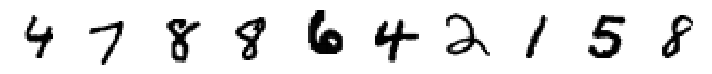

Images created by untrained generator


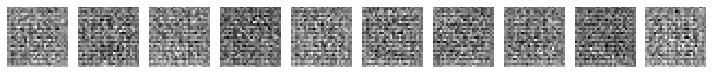

In [ ]:
#display real MNIST digits and ones currently made by the untrained generator
print("Real MNIST images")
plot_images(generator, latent_dim, dataset, True)
print("Images created by untrained generator")
plot_images(generator, latent_dim, dataset, False)

Epoch Number: 1 Epoch Batch Progress: 1/234 Discriminator Loss: 0.690
Epoch Number: 1 Epoch Batch Progress: 2/234 Discriminator Loss: 0.686
Epoch Number: 1 Epoch Batch Progress: 3/234 Discriminator Loss: 0.679
Epoch Number: 1 Epoch Batch Progress: 4/234 Discriminator Loss: 0.670
Epoch Number: 1 Epoch Batch Progress: 5/234 Discriminator Loss: 0.662
Epoch Number: 1 Epoch Batch Progress: 6/234 Discriminator Loss: 0.655
Epoch Number: 1 Epoch Batch Progress: 7/234 Discriminator Loss: 0.653
Epoch Number: 1 Epoch Batch Progress: 8/234 Discriminator Loss: 0.651
Epoch Number: 1 Epoch Batch Progress: 9/234 Discriminator Loss: 0.642
Epoch Number: 1 Epoch Batch Progress: 10/234 Discriminator Loss: 0.643
Epoch Number: 1 Epoch Batch Progress: 11/234 Discriminator Loss: 0.645
Epoch Number: 1 Epoch Batch Progress: 12/234 Discriminator Loss: 0.650
Epoch Number: 1 Epoch Batch Progress: 13/234 Discriminator Loss: 0.657
Epoch Number: 1 Epoch Batch Progress: 14/234 Discriminator Loss: 0.664
Epoch Number: 1

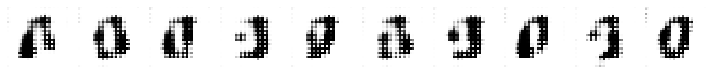

Epoch Number: 2 Epoch Batch Progress: 1/234 Discriminator Loss: 0.690
Epoch Number: 2 Epoch Batch Progress: 2/234 Discriminator Loss: 0.720
Epoch Number: 2 Epoch Batch Progress: 3/234 Discriminator Loss: 0.733
Epoch Number: 2 Epoch Batch Progress: 4/234 Discriminator Loss: 0.729
Epoch Number: 2 Epoch Batch Progress: 5/234 Discriminator Loss: 0.710
Epoch Number: 2 Epoch Batch Progress: 6/234 Discriminator Loss: 0.702
Epoch Number: 2 Epoch Batch Progress: 7/234 Discriminator Loss: 0.690
Epoch Number: 2 Epoch Batch Progress: 8/234 Discriminator Loss: 0.687
Epoch Number: 2 Epoch Batch Progress: 9/234 Discriminator Loss: 0.665
Epoch Number: 2 Epoch Batch Progress: 10/234 Discriminator Loss: 0.631
Epoch Number: 2 Epoch Batch Progress: 11/234 Discriminator Loss: 0.640
Epoch Number: 2 Epoch Batch Progress: 12/234 Discriminator Loss: 0.652
Epoch Number: 2 Epoch Batch Progress: 13/234 Discriminator Loss: 0.668
Epoch Number: 2 Epoch Batch Progress: 14/234 Discriminator Loss: 0.670
Epoch Number: 2

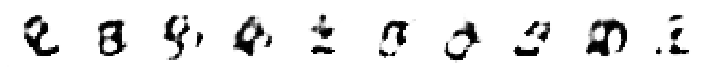

Epoch Number: 6 Epoch Batch Progress: 1/234 Discriminator Loss: 0.699
Epoch Number: 6 Epoch Batch Progress: 2/234 Discriminator Loss: 0.698
Epoch Number: 6 Epoch Batch Progress: 3/234 Discriminator Loss: 0.700
Epoch Number: 6 Epoch Batch Progress: 4/234 Discriminator Loss: 0.703
Epoch Number: 6 Epoch Batch Progress: 5/234 Discriminator Loss: 0.715
Epoch Number: 6 Epoch Batch Progress: 6/234 Discriminator Loss: 0.700
Epoch Number: 6 Epoch Batch Progress: 7/234 Discriminator Loss: 0.700
Epoch Number: 6 Epoch Batch Progress: 8/234 Discriminator Loss: 0.695
Epoch Number: 6 Epoch Batch Progress: 9/234 Discriminator Loss: 0.708
Epoch Number: 6 Epoch Batch Progress: 10/234 Discriminator Loss: 0.700
Epoch Number: 6 Epoch Batch Progress: 11/234 Discriminator Loss: 0.702
Epoch Number: 6 Epoch Batch Progress: 12/234 Discriminator Loss: 0.700
Epoch Number: 6 Epoch Batch Progress: 13/234 Discriminator Loss: 0.693
Epoch Number: 6 Epoch Batch Progress: 14/234 Discriminator Loss: 0.692
Epoch Number: 6

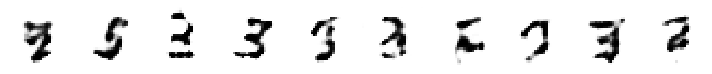

Epoch Number: 11 Epoch Batch Progress: 1/234 Discriminator Loss: 0.674
Epoch Number: 11 Epoch Batch Progress: 2/234 Discriminator Loss: 0.679
Epoch Number: 11 Epoch Batch Progress: 3/234 Discriminator Loss: 0.673
Epoch Number: 11 Epoch Batch Progress: 4/234 Discriminator Loss: 0.681
Epoch Number: 11 Epoch Batch Progress: 5/234 Discriminator Loss: 0.675
Epoch Number: 11 Epoch Batch Progress: 6/234 Discriminator Loss: 0.678
Epoch Number: 11 Epoch Batch Progress: 7/234 Discriminator Loss: 0.683
Epoch Number: 11 Epoch Batch Progress: 8/234 Discriminator Loss: 0.678
Epoch Number: 11 Epoch Batch Progress: 9/234 Discriminator Loss: 0.677
Epoch Number: 11 Epoch Batch Progress: 10/234 Discriminator Loss: 0.681
Epoch Number: 11 Epoch Batch Progress: 11/234 Discriminator Loss: 0.681
Epoch Number: 11 Epoch Batch Progress: 12/234 Discriminator Loss: 0.683
Epoch Number: 11 Epoch Batch Progress: 13/234 Discriminator Loss: 0.686
Epoch Number: 11 Epoch Batch Progress: 14/234 Discriminator Loss: 0.682
E

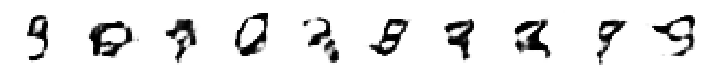

Epoch Number: 16 Epoch Batch Progress: 1/234 Discriminator Loss: 0.683
Epoch Number: 16 Epoch Batch Progress: 2/234 Discriminator Loss: 0.688
Epoch Number: 16 Epoch Batch Progress: 3/234 Discriminator Loss: 0.686
Epoch Number: 16 Epoch Batch Progress: 4/234 Discriminator Loss: 0.689
Epoch Number: 16 Epoch Batch Progress: 5/234 Discriminator Loss: 0.695
Epoch Number: 16 Epoch Batch Progress: 6/234 Discriminator Loss: 0.688
Epoch Number: 16 Epoch Batch Progress: 7/234 Discriminator Loss: 0.687
Epoch Number: 16 Epoch Batch Progress: 8/234 Discriminator Loss: 0.689
Epoch Number: 16 Epoch Batch Progress: 9/234 Discriminator Loss: 0.681
Epoch Number: 16 Epoch Batch Progress: 10/234 Discriminator Loss: 0.686
Epoch Number: 16 Epoch Batch Progress: 11/234 Discriminator Loss: 0.692
Epoch Number: 16 Epoch Batch Progress: 12/234 Discriminator Loss: 0.674
Epoch Number: 16 Epoch Batch Progress: 13/234 Discriminator Loss: 0.680
Epoch Number: 16 Epoch Batch Progress: 14/234 Discriminator Loss: 0.675
E

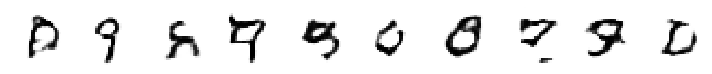

Epoch Number: 21 Epoch Batch Progress: 1/234 Discriminator Loss: 0.696
Epoch Number: 21 Epoch Batch Progress: 2/234 Discriminator Loss: 0.691
Epoch Number: 21 Epoch Batch Progress: 3/234 Discriminator Loss: 0.689
Epoch Number: 21 Epoch Batch Progress: 4/234 Discriminator Loss: 0.684
Epoch Number: 21 Epoch Batch Progress: 5/234 Discriminator Loss: 0.690
Epoch Number: 21 Epoch Batch Progress: 6/234 Discriminator Loss: 0.684
Epoch Number: 21 Epoch Batch Progress: 7/234 Discriminator Loss: 0.683
Epoch Number: 21 Epoch Batch Progress: 8/234 Discriminator Loss: 0.686
Epoch Number: 21 Epoch Batch Progress: 9/234 Discriminator Loss: 0.683
Epoch Number: 21 Epoch Batch Progress: 10/234 Discriminator Loss: 0.686
Epoch Number: 21 Epoch Batch Progress: 11/234 Discriminator Loss: 0.683
Epoch Number: 21 Epoch Batch Progress: 12/234 Discriminator Loss: 0.696
Epoch Number: 21 Epoch Batch Progress: 13/234 Discriminator Loss: 0.678
Epoch Number: 21 Epoch Batch Progress: 14/234 Discriminator Loss: 0.678
E

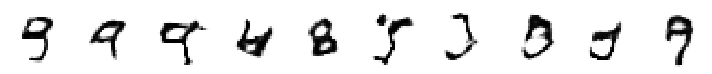

Epoch Number: 26 Epoch Batch Progress: 1/234 Discriminator Loss: 0.684
Epoch Number: 26 Epoch Batch Progress: 2/234 Discriminator Loss: 0.686
Epoch Number: 26 Epoch Batch Progress: 3/234 Discriminator Loss: 0.682
Epoch Number: 26 Epoch Batch Progress: 4/234 Discriminator Loss: 0.686
Epoch Number: 26 Epoch Batch Progress: 5/234 Discriminator Loss: 0.687
Epoch Number: 26 Epoch Batch Progress: 6/234 Discriminator Loss: 0.685
Epoch Number: 26 Epoch Batch Progress: 7/234 Discriminator Loss: 0.684
Epoch Number: 26 Epoch Batch Progress: 8/234 Discriminator Loss: 0.682
Epoch Number: 26 Epoch Batch Progress: 9/234 Discriminator Loss: 0.685
Epoch Number: 26 Epoch Batch Progress: 10/234 Discriminator Loss: 0.676
Epoch Number: 26 Epoch Batch Progress: 11/234 Discriminator Loss: 0.684
Epoch Number: 26 Epoch Batch Progress: 12/234 Discriminator Loss: 0.694
Epoch Number: 26 Epoch Batch Progress: 13/234 Discriminator Loss: 0.667
Epoch Number: 26 Epoch Batch Progress: 14/234 Discriminator Loss: 0.676
E

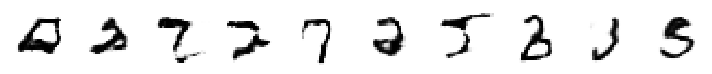

Epoch Number: 31 Epoch Batch Progress: 1/234 Discriminator Loss: 0.676
Epoch Number: 31 Epoch Batch Progress: 2/234 Discriminator Loss: 0.684
Epoch Number: 31 Epoch Batch Progress: 3/234 Discriminator Loss: 0.686
Epoch Number: 31 Epoch Batch Progress: 4/234 Discriminator Loss: 0.689
Epoch Number: 31 Epoch Batch Progress: 5/234 Discriminator Loss: 0.693
Epoch Number: 31 Epoch Batch Progress: 6/234 Discriminator Loss: 0.689
Epoch Number: 31 Epoch Batch Progress: 7/234 Discriminator Loss: 0.690
Epoch Number: 31 Epoch Batch Progress: 8/234 Discriminator Loss: 0.689
Epoch Number: 31 Epoch Batch Progress: 9/234 Discriminator Loss: 0.689
Epoch Number: 31 Epoch Batch Progress: 10/234 Discriminator Loss: 0.680
Epoch Number: 31 Epoch Batch Progress: 11/234 Discriminator Loss: 0.678
Epoch Number: 31 Epoch Batch Progress: 12/234 Discriminator Loss: 0.684
Epoch Number: 31 Epoch Batch Progress: 13/234 Discriminator Loss: 0.697
Epoch Number: 31 Epoch Batch Progress: 14/234 Discriminator Loss: 0.695
E

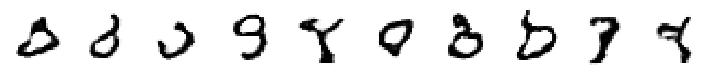

Epoch Number: 36 Epoch Batch Progress: 1/234 Discriminator Loss: 0.668
Epoch Number: 36 Epoch Batch Progress: 2/234 Discriminator Loss: 0.685
Epoch Number: 36 Epoch Batch Progress: 3/234 Discriminator Loss: 0.691
Epoch Number: 36 Epoch Batch Progress: 4/234 Discriminator Loss: 0.686
Epoch Number: 36 Epoch Batch Progress: 5/234 Discriminator Loss: 0.687
Epoch Number: 36 Epoch Batch Progress: 6/234 Discriminator Loss: 0.689
Epoch Number: 36 Epoch Batch Progress: 7/234 Discriminator Loss: 0.678
Epoch Number: 36 Epoch Batch Progress: 8/234 Discriminator Loss: 0.690
Epoch Number: 36 Epoch Batch Progress: 9/234 Discriminator Loss: 0.691
Epoch Number: 36 Epoch Batch Progress: 10/234 Discriminator Loss: 0.688
Epoch Number: 36 Epoch Batch Progress: 11/234 Discriminator Loss: 0.685
Epoch Number: 36 Epoch Batch Progress: 12/234 Discriminator Loss: 0.687
Epoch Number: 36 Epoch Batch Progress: 13/234 Discriminator Loss: 0.684
Epoch Number: 36 Epoch Batch Progress: 14/234 Discriminator Loss: 0.692
E

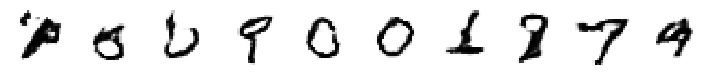

Epoch Number: 41 Epoch Batch Progress: 1/234 Discriminator Loss: 0.686
Epoch Number: 41 Epoch Batch Progress: 2/234 Discriminator Loss: 0.685
Epoch Number: 41 Epoch Batch Progress: 3/234 Discriminator Loss: 0.675
Epoch Number: 41 Epoch Batch Progress: 4/234 Discriminator Loss: 0.689
Epoch Number: 41 Epoch Batch Progress: 5/234 Discriminator Loss: 0.691
Epoch Number: 41 Epoch Batch Progress: 6/234 Discriminator Loss: 0.687
Epoch Number: 41 Epoch Batch Progress: 7/234 Discriminator Loss: 0.687
Epoch Number: 41 Epoch Batch Progress: 8/234 Discriminator Loss: 0.681
Epoch Number: 41 Epoch Batch Progress: 9/234 Discriminator Loss: 0.689
Epoch Number: 41 Epoch Batch Progress: 10/234 Discriminator Loss: 0.692
Epoch Number: 41 Epoch Batch Progress: 11/234 Discriminator Loss: 0.687
Epoch Number: 41 Epoch Batch Progress: 12/234 Discriminator Loss: 0.690
Epoch Number: 41 Epoch Batch Progress: 13/234 Discriminator Loss: 0.683
Epoch Number: 41 Epoch Batch Progress: 14/234 Discriminator Loss: 0.687
E

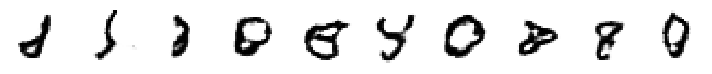

Epoch Number: 46 Epoch Batch Progress: 1/234 Discriminator Loss: 0.687
Epoch Number: 46 Epoch Batch Progress: 2/234 Discriminator Loss: 0.691
Epoch Number: 46 Epoch Batch Progress: 3/234 Discriminator Loss: 0.693
Epoch Number: 46 Epoch Batch Progress: 4/234 Discriminator Loss: 0.690
Epoch Number: 46 Epoch Batch Progress: 5/234 Discriminator Loss: 0.679
Epoch Number: 46 Epoch Batch Progress: 6/234 Discriminator Loss: 0.692
Epoch Number: 46 Epoch Batch Progress: 7/234 Discriminator Loss: 0.685
Epoch Number: 46 Epoch Batch Progress: 8/234 Discriminator Loss: 0.685
Epoch Number: 46 Epoch Batch Progress: 9/234 Discriminator Loss: 0.681
Epoch Number: 46 Epoch Batch Progress: 10/234 Discriminator Loss: 0.689
Epoch Number: 46 Epoch Batch Progress: 11/234 Discriminator Loss: 0.681
Epoch Number: 46 Epoch Batch Progress: 12/234 Discriminator Loss: 0.691
Epoch Number: 46 Epoch Batch Progress: 13/234 Discriminator Loss: 0.691
Epoch Number: 46 Epoch Batch Progress: 14/234 Discriminator Loss: 0.694
E

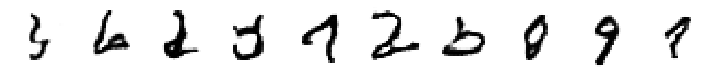

Epoch Number: 51 Epoch Batch Progress: 1/234 Discriminator Loss: 0.691
Epoch Number: 51 Epoch Batch Progress: 2/234 Discriminator Loss: 0.692
Epoch Number: 51 Epoch Batch Progress: 3/234 Discriminator Loss: 0.684
Epoch Number: 51 Epoch Batch Progress: 4/234 Discriminator Loss: 0.686
Epoch Number: 51 Epoch Batch Progress: 5/234 Discriminator Loss: 0.695
Epoch Number: 51 Epoch Batch Progress: 6/234 Discriminator Loss: 0.691
Epoch Number: 51 Epoch Batch Progress: 7/234 Discriminator Loss: 0.697
Epoch Number: 51 Epoch Batch Progress: 8/234 Discriminator Loss: 0.685
Epoch Number: 51 Epoch Batch Progress: 9/234 Discriminator Loss: 0.687
Epoch Number: 51 Epoch Batch Progress: 10/234 Discriminator Loss: 0.700
Epoch Number: 51 Epoch Batch Progress: 11/234 Discriminator Loss: 0.694
Epoch Number: 51 Epoch Batch Progress: 12/234 Discriminator Loss: 0.691
Epoch Number: 51 Epoch Batch Progress: 13/234 Discriminator Loss: 0.694
Epoch Number: 51 Epoch Batch Progress: 14/234 Discriminator Loss: 0.679
E

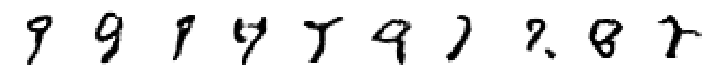

Epoch Number: 56 Epoch Batch Progress: 1/234 Discriminator Loss: 0.685
Epoch Number: 56 Epoch Batch Progress: 2/234 Discriminator Loss: 0.688
Epoch Number: 56 Epoch Batch Progress: 3/234 Discriminator Loss: 0.689
Epoch Number: 56 Epoch Batch Progress: 4/234 Discriminator Loss: 0.682
Epoch Number: 56 Epoch Batch Progress: 5/234 Discriminator Loss: 0.694
Epoch Number: 56 Epoch Batch Progress: 6/234 Discriminator Loss: 0.686
Epoch Number: 56 Epoch Batch Progress: 7/234 Discriminator Loss: 0.682
Epoch Number: 56 Epoch Batch Progress: 8/234 Discriminator Loss: 0.689
Epoch Number: 56 Epoch Batch Progress: 9/234 Discriminator Loss: 0.696
Epoch Number: 56 Epoch Batch Progress: 10/234 Discriminator Loss: 0.683
Epoch Number: 56 Epoch Batch Progress: 11/234 Discriminator Loss: 0.700
Epoch Number: 56 Epoch Batch Progress: 12/234 Discriminator Loss: 0.681
Epoch Number: 56 Epoch Batch Progress: 13/234 Discriminator Loss: 0.688
Epoch Number: 56 Epoch Batch Progress: 14/234 Discriminator Loss: 0.698
E

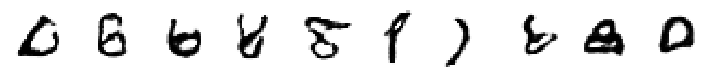

Epoch Number: 61 Epoch Batch Progress: 1/234 Discriminator Loss: 0.686
Epoch Number: 61 Epoch Batch Progress: 2/234 Discriminator Loss: 0.688
Epoch Number: 61 Epoch Batch Progress: 3/234 Discriminator Loss: 0.694
Epoch Number: 61 Epoch Batch Progress: 4/234 Discriminator Loss: 0.691
Epoch Number: 61 Epoch Batch Progress: 5/234 Discriminator Loss: 0.700
Epoch Number: 61 Epoch Batch Progress: 6/234 Discriminator Loss: 0.682
Epoch Number: 61 Epoch Batch Progress: 7/234 Discriminator Loss: 0.697
Epoch Number: 61 Epoch Batch Progress: 8/234 Discriminator Loss: 0.692
Epoch Number: 61 Epoch Batch Progress: 9/234 Discriminator Loss: 0.689
Epoch Number: 61 Epoch Batch Progress: 10/234 Discriminator Loss: 0.699
Epoch Number: 61 Epoch Batch Progress: 11/234 Discriminator Loss: 0.689
Epoch Number: 61 Epoch Batch Progress: 12/234 Discriminator Loss: 0.692
Epoch Number: 61 Epoch Batch Progress: 13/234 Discriminator Loss: 0.697
Epoch Number: 61 Epoch Batch Progress: 14/234 Discriminator Loss: 0.689
E

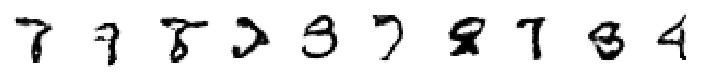

Epoch Number: 66 Epoch Batch Progress: 1/234 Discriminator Loss: 0.692
Epoch Number: 66 Epoch Batch Progress: 2/234 Discriminator Loss: 0.693
Epoch Number: 66 Epoch Batch Progress: 3/234 Discriminator Loss: 0.690
Epoch Number: 66 Epoch Batch Progress: 4/234 Discriminator Loss: 0.693
Epoch Number: 66 Epoch Batch Progress: 5/234 Discriminator Loss: 0.687
Epoch Number: 66 Epoch Batch Progress: 6/234 Discriminator Loss: 0.686
Epoch Number: 66 Epoch Batch Progress: 7/234 Discriminator Loss: 0.692
Epoch Number: 66 Epoch Batch Progress: 8/234 Discriminator Loss: 0.690
Epoch Number: 66 Epoch Batch Progress: 9/234 Discriminator Loss: 0.686
Epoch Number: 66 Epoch Batch Progress: 10/234 Discriminator Loss: 0.699
Epoch Number: 66 Epoch Batch Progress: 11/234 Discriminator Loss: 0.692
Epoch Number: 66 Epoch Batch Progress: 12/234 Discriminator Loss: 0.687
Epoch Number: 66 Epoch Batch Progress: 13/234 Discriminator Loss: 0.695
Epoch Number: 66 Epoch Batch Progress: 14/234 Discriminator Loss: 0.693
E

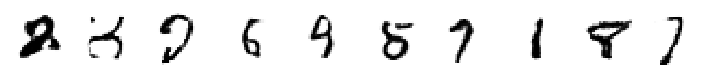

Epoch Number: 71 Epoch Batch Progress: 1/234 Discriminator Loss: 0.692
Epoch Number: 71 Epoch Batch Progress: 2/234 Discriminator Loss: 0.694
Epoch Number: 71 Epoch Batch Progress: 3/234 Discriminator Loss: 0.687
Epoch Number: 71 Epoch Batch Progress: 4/234 Discriminator Loss: 0.701
Epoch Number: 71 Epoch Batch Progress: 5/234 Discriminator Loss: 0.688
Epoch Number: 71 Epoch Batch Progress: 6/234 Discriminator Loss: 0.691
Epoch Number: 71 Epoch Batch Progress: 7/234 Discriminator Loss: 0.694
Epoch Number: 71 Epoch Batch Progress: 8/234 Discriminator Loss: 0.689
Epoch Number: 71 Epoch Batch Progress: 9/234 Discriminator Loss: 0.690
Epoch Number: 71 Epoch Batch Progress: 10/234 Discriminator Loss: 0.697
Epoch Number: 71 Epoch Batch Progress: 11/234 Discriminator Loss: 0.683
Epoch Number: 71 Epoch Batch Progress: 12/234 Discriminator Loss: 0.690
Epoch Number: 71 Epoch Batch Progress: 13/234 Discriminator Loss: 0.693
Epoch Number: 71 Epoch Batch Progress: 14/234 Discriminator Loss: 0.680
E

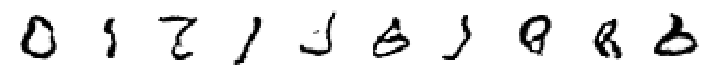

Epoch Number: 76 Epoch Batch Progress: 1/234 Discriminator Loss: 0.675
Epoch Number: 76 Epoch Batch Progress: 2/234 Discriminator Loss: 0.695
Epoch Number: 76 Epoch Batch Progress: 3/234 Discriminator Loss: 0.680
Epoch Number: 76 Epoch Batch Progress: 4/234 Discriminator Loss: 0.691
Epoch Number: 76 Epoch Batch Progress: 5/234 Discriminator Loss: 0.684
Epoch Number: 76 Epoch Batch Progress: 6/234 Discriminator Loss: 0.691
Epoch Number: 76 Epoch Batch Progress: 7/234 Discriminator Loss: 0.682
Epoch Number: 76 Epoch Batch Progress: 8/234 Discriminator Loss: 0.687
Epoch Number: 76 Epoch Batch Progress: 9/234 Discriminator Loss: 0.700
Epoch Number: 76 Epoch Batch Progress: 10/234 Discriminator Loss: 0.683
Epoch Number: 76 Epoch Batch Progress: 11/234 Discriminator Loss: 0.680
Epoch Number: 76 Epoch Batch Progress: 12/234 Discriminator Loss: 0.694
Epoch Number: 76 Epoch Batch Progress: 13/234 Discriminator Loss: 0.694
Epoch Number: 76 Epoch Batch Progress: 14/234 Discriminator Loss: 0.689
E

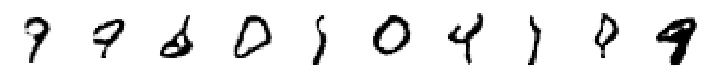

Epoch Number: 81 Epoch Batch Progress: 1/234 Discriminator Loss: 0.691
Epoch Number: 81 Epoch Batch Progress: 2/234 Discriminator Loss: 0.688
Epoch Number: 81 Epoch Batch Progress: 3/234 Discriminator Loss: 0.692
Epoch Number: 81 Epoch Batch Progress: 4/234 Discriminator Loss: 0.692
Epoch Number: 81 Epoch Batch Progress: 5/234 Discriminator Loss: 0.684
Epoch Number: 81 Epoch Batch Progress: 6/234 Discriminator Loss: 0.689
Epoch Number: 81 Epoch Batch Progress: 7/234 Discriminator Loss: 0.699
Epoch Number: 81 Epoch Batch Progress: 8/234 Discriminator Loss: 0.686
Epoch Number: 81 Epoch Batch Progress: 9/234 Discriminator Loss: 0.691
Epoch Number: 81 Epoch Batch Progress: 10/234 Discriminator Loss: 0.705
Epoch Number: 81 Epoch Batch Progress: 11/234 Discriminator Loss: 0.690
Epoch Number: 81 Epoch Batch Progress: 12/234 Discriminator Loss: 0.691
Epoch Number: 81 Epoch Batch Progress: 13/234 Discriminator Loss: 0.689
Epoch Number: 81 Epoch Batch Progress: 14/234 Discriminator Loss: 0.687
E

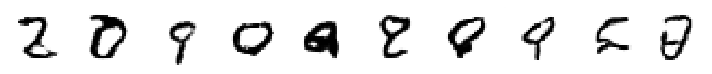

Epoch Number: 86 Epoch Batch Progress: 1/234 Discriminator Loss: 0.683
Epoch Number: 86 Epoch Batch Progress: 2/234 Discriminator Loss: 0.686
Epoch Number: 86 Epoch Batch Progress: 3/234 Discriminator Loss: 0.691
Epoch Number: 86 Epoch Batch Progress: 4/234 Discriminator Loss: 0.695
Epoch Number: 86 Epoch Batch Progress: 5/234 Discriminator Loss: 0.695
Epoch Number: 86 Epoch Batch Progress: 6/234 Discriminator Loss: 0.688
Epoch Number: 86 Epoch Batch Progress: 7/234 Discriminator Loss: 0.694
Epoch Number: 86 Epoch Batch Progress: 8/234 Discriminator Loss: 0.687
Epoch Number: 86 Epoch Batch Progress: 9/234 Discriminator Loss: 0.686
Epoch Number: 86 Epoch Batch Progress: 10/234 Discriminator Loss: 0.690
Epoch Number: 86 Epoch Batch Progress: 11/234 Discriminator Loss: 0.691
Epoch Number: 86 Epoch Batch Progress: 12/234 Discriminator Loss: 0.690
Epoch Number: 86 Epoch Batch Progress: 13/234 Discriminator Loss: 0.696
Epoch Number: 86 Epoch Batch Progress: 14/234 Discriminator Loss: 0.691
E

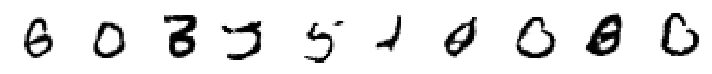

Epoch Number: 91 Epoch Batch Progress: 1/234 Discriminator Loss: 0.688
Epoch Number: 91 Epoch Batch Progress: 2/234 Discriminator Loss: 0.690
Epoch Number: 91 Epoch Batch Progress: 3/234 Discriminator Loss: 0.696
Epoch Number: 91 Epoch Batch Progress: 4/234 Discriminator Loss: 0.693
Epoch Number: 91 Epoch Batch Progress: 5/234 Discriminator Loss: 0.691
Epoch Number: 91 Epoch Batch Progress: 6/234 Discriminator Loss: 0.698
Epoch Number: 91 Epoch Batch Progress: 7/234 Discriminator Loss: 0.691
Epoch Number: 91 Epoch Batch Progress: 8/234 Discriminator Loss: 0.693
Epoch Number: 91 Epoch Batch Progress: 9/234 Discriminator Loss: 0.691
Epoch Number: 91 Epoch Batch Progress: 10/234 Discriminator Loss: 0.692
Epoch Number: 91 Epoch Batch Progress: 11/234 Discriminator Loss: 0.693
Epoch Number: 91 Epoch Batch Progress: 12/234 Discriminator Loss: 0.696
Epoch Number: 91 Epoch Batch Progress: 13/234 Discriminator Loss: 0.692
Epoch Number: 91 Epoch Batch Progress: 14/234 Discriminator Loss: 0.692
E

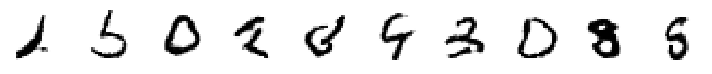

Epoch Number: 96 Epoch Batch Progress: 1/234 Discriminator Loss: 0.694
Epoch Number: 96 Epoch Batch Progress: 2/234 Discriminator Loss: 0.683
Epoch Number: 96 Epoch Batch Progress: 3/234 Discriminator Loss: 0.686
Epoch Number: 96 Epoch Batch Progress: 4/234 Discriminator Loss: 0.689
Epoch Number: 96 Epoch Batch Progress: 5/234 Discriminator Loss: 0.690
Epoch Number: 96 Epoch Batch Progress: 6/234 Discriminator Loss: 0.692
Epoch Number: 96 Epoch Batch Progress: 7/234 Discriminator Loss: 0.699
Epoch Number: 96 Epoch Batch Progress: 8/234 Discriminator Loss: 0.686
Epoch Number: 96 Epoch Batch Progress: 9/234 Discriminator Loss: 0.690
Epoch Number: 96 Epoch Batch Progress: 10/234 Discriminator Loss: 0.697
Epoch Number: 96 Epoch Batch Progress: 11/234 Discriminator Loss: 0.688
Epoch Number: 96 Epoch Batch Progress: 12/234 Discriminator Loss: 0.687
Epoch Number: 96 Epoch Batch Progress: 13/234 Discriminator Loss: 0.694
Epoch Number: 96 Epoch Batch Progress: 14/234 Discriminator Loss: 0.694
E

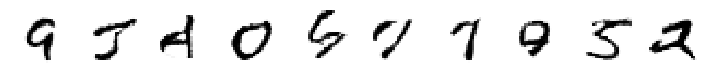

In [ ]:
#train gan model, displaying epoch progress and summarizing performance after every five epochs
train(generator, discriminator, gan_model, dataset, latent_dim)

Real MNIST images


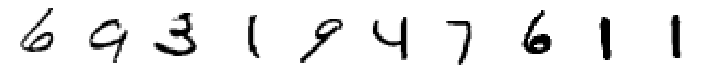

Images created by trained generator


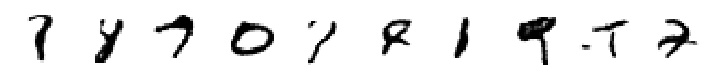

In [ ]:
#now display MNIST images against the images produced by the now trained generator
print("Real MNIST images")
plot_images(generator, latent_dim, dataset, True)
print("Images created by trained generator")
plot_images(generator, latent_dim, dataset, False)